In [1]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
import nltk
import torch, torchhd
import torchtext.datasets as datasets
from torch.utils.data import DataLoader
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/senn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
batch_size = 100

# Data src info: https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/
data_pipe = datasets.WikiText2(root="../data", split=("train"))
# data_pipe = datasets.WikiText103(root="../data", split=("train"))
# data_pipe = data_pipe.map(partial(sent_tokenize, language="english"))
data_pipe = data_pipe.batch(batch_size)

data_loader = DataLoader(data_pipe, batch_size=None, shuffle=False)
# data_loader = DataLoader(data_pipe, batch_size=1, shuffle=False)

In [4]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)
    
class Document(object):
    def __init__(self, title='', text=['']):
        self.dictionary = Dictionary()
        self.set_title(title)
        self.set_text(text)
    
    def set_title(self, title):
        self.title = title

    def set_text(self, text):
        self.text = text
        self.dictionary = Dictionary()
        for word in set(text):
            self.dictionary.add_word(word)
    
class WikiTextDataset(object):
    """Tokenization and vocabulary building for text corpus."""

    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.documents: list[Document] = []
        self.dictionary = Dictionary()
        self.corpus = []
        self.max_documents = 3000

        self.process_data()

    def process_data(self):
        """
          Tokenize the lines, remove the titles, and make it lowercase,
          return lines list.
          list[list[word]]
        """
        current_text_tokens = []
        current_title = ''

        for batch in tqdm(self.data_loader):
            for text_fragment in batch:
                # if text fragment contains exactly 2 = signs, it is a title
                if text_fragment.count("=") == 2:
                    if current_text_tokens:
                      self._add_document(current_title, current_text_tokens)
                    
                    current_title = text_fragment.replace("=", "").strip()
                    current_text_tokens = []
                    if len(self.documents) == self.max_documents:
                        return
                    continue
                
                sentence_tokenized = self._process_text_fragment(text_fragment)
                if sentence_tokenized:
                    current_text_tokens.extend(sentence_tokenized)
                    for word in sentence_tokenized:
                        self.dictionary.add_word(word)
    
    def _add_document(self, title, text):
        doc = Document(title, text)
        self.documents.append(doc)

    def _process_text_fragment(self, text_fragment):
        # skip subheadings
        if "==" in text_fragment:
            return
        # skip empty lines
        if text_fragment.strip() == "":
            return
        # remove <unk> tokens
        text_fragment = text_fragment.replace("<unk>", "")

        # sentence_tokenized = [word_tokenize(sentence) for sentence in sent_tokenize(text_fragment)]
        # sentence_tokenized = [[word.lower() for word in sentence] for sentence in sentence_tokenized]
        sentence_tokenized = gensim.utils.simple_preprocess(text_fragment, deacc=True)
        sentence_tokenized = gensim.parsing.preprocessing.remove_stopword_tokens(sentence_tokenized)
        return sentence_tokenized

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, token):
        return self.documents[token]

    def __iter__(self):
        return iter(self.documents)
    
    def get_word_frequency(self, word, document_frequency=False):
        if document_frequency:
            return sum([word in doc.dictionary.idx2word for doc in self.documents])
        return sum([doc.text.count(word) for doc in self.documents])


In [5]:
# for i, batch in enumerate(data_loader):
#     print(i, batch)
#     if i > 100:
#         break   
wiki_text_dataset = WikiTextDataset(data_loader)

368it [00:02, 135.07it/s]


In [6]:
print(f'Number of documents: {len(wiki_text_dataset)}')
print(f'Title of first document: {wiki_text_dataset[0].title}')
print(f'First 10 words of first document: {wiki_text_dataset[0].text[:10]}')
print(f'Length of first document: {len(wiki_text_dataset[0].text)}')
print(f'Number of elements in dictionary of first document: {len(wiki_text_dataset[0].dictionary)}')
print(f'Number of elements in the vocabulary: {len(wiki_text_dataset.dictionary)}')

Number of documents: 628
Title of first document: Valkyria Chronicles III
First 10 words of first document: ['senjo', 'valkyria', 'chronicles', 'japanese', '戦場のウァルキュリア', 'lit', 'valkyria', 'battlefield', 'commonly', 'referred']
Length of first document: 1609
Number of elements in dictionary of first document: 802
Number of elements in the vocabulary: 26850


### Onto HD Vectors

In [7]:
DIMENSIONS = 10_000
vocab_size = len(wiki_text_dataset.dictionary)
vsa_type= 'MAP'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

def norm_hamming_similarity(x, y):
    normalisation_factor = x.shape[1] if x.ndim == 2 else x.shape[0]
    sim = torchhd.hamming_similarity(x, y)
    norm_sim = sim / normalisation_factor
    return norm_sim

def similarity_func_partial(vsa_type, x, y):
    if vsa_type == 'BSC':
        return norm_hamming_similarity(x, y)
    else:
        return torchhd.cosine_similarity(x, y)

sim_func = partial(similarity_func_partial, vsa_type)

Using cuda device


In [8]:
# label_embeddings = torchhd.random(vocab_size, DIMENSIONS, device=device, vsa=vsa_type)
document_embeddings = torchhd.random(len(wiki_text_dataset), DIMENSIONS, device=device, vsa=vsa_type)
learned_embeddings = torchhd.empty(vocab_size, DIMENSIONS, device=device, vsa=vsa_type)

### Learning the word embeddings

In [9]:
for doc_idx, document in enumerate(tqdm(wiki_text_dataset)):
    document_embedding = document_embeddings[doc_idx]
    for word in document.dictionary.idx2word:
        word_idx = wiki_text_dataset.dictionary.word2idx[word] # wrong
        # word_embedding = label_embeddings[word_idx]
        learned_embeddings[word_idx] = learned_embeddings[word_idx].bundle(document_embedding) # Bundle is not in-place

100%|██████████| 628/628 [00:21<00:00, 28.98it/s]


In [10]:
# get most similar vectors to word
def get_k_most_similar_words(target_word, learned_memory, k=10, label_memory=None, dictionary=wiki_text_dataset.dictionary):
    word_idx = dictionary.word2idx[target_word]
    word_vector = learned_memory[word_idx]
    comparable_memory = label_memory if label_memory is not None else learned_memory
    similar_vectors = sim_func(word_vector, comparable_memory)
    similar_vector_idxs = torch.argsort(similar_vectors, descending=True)[:k]
    return [(dictionary.idx2word[idx], round(similar_vectors[idx].item(), 3)) for idx in similar_vector_idxs]

def plot_k_most_similar_words(target_word, memory, k=10):
    similar_vectors = get_k_most_similar_words(target_word, memory, k)
    similar_words, similarities = zip(*similar_vectors)
    fig, ax = plt.subplots()
    ax.bar(similar_words, similarities)
    # ax = sns.barplot(x=similar_words, y=similarities)
    ax.set_title(f"Most similar words to {target_word}")
    ax.set_xlabel("Similarity")
    ax.set_ylabel("Word")
    ax.bar_label(ax.containers[0])
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    # plt.xticks(rotation=90)
    # plt.show()

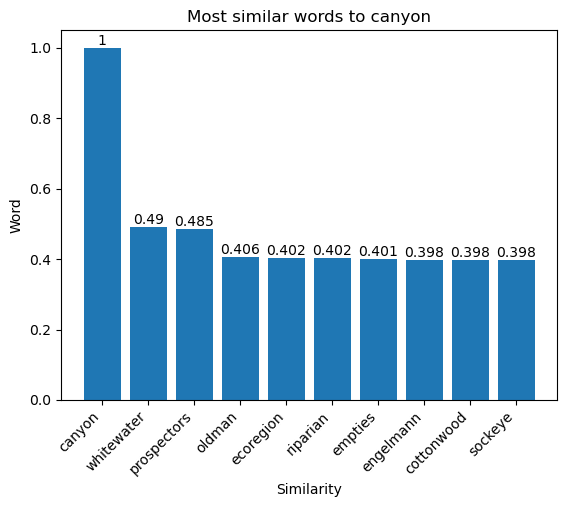

In [11]:
reference_word = "canyon"
plot_k_most_similar_words(reference_word, learned_embeddings)

### similarity of random vocabulary word to other words in the vocabulary

In [13]:
reference_vector = learned_embeddings[wiki_text_dataset.dictionary.word2idx[reference_word]]
similarities = sim_func(reference_vector, learned_embeddings)

Text(0, 0.5, 'Frequency')

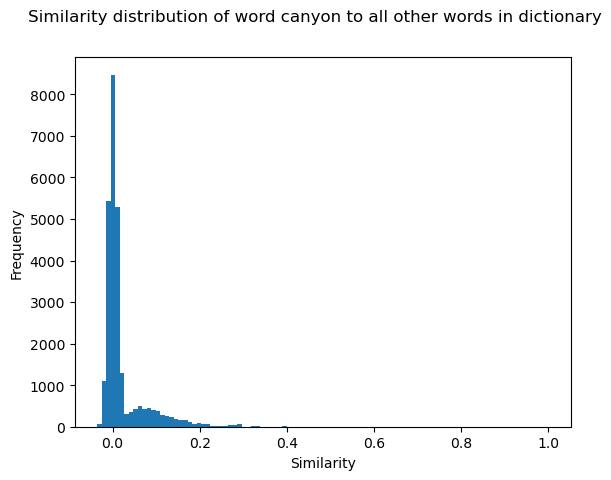

In [14]:
fig, ax = plt.subplots()
fig.suptitle(f"Similarity distribution of word {reference_word} to all other words in dictionary")
ax.hist(similarities.cpu().numpy(), bins=100)
ax.set_xlabel("Similarity")
ax.set_ylabel("Frequency")


### Wordsim353 validation

In [ ]:
class Wordsim353Loader(object):
    def __init__(self, path):
        self.path = path
        self.data = self.load_data()

    def load_data(self):
        with open(self.path, "r") as f:
            lines = f.readlines()
        lines = [line.strip().split("\t") for line in lines]
        lines = [line for line in lines if len(line) == 3]
        return lines

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)
    
wordsim353_loader = Wordsim353Loader("../../data_external/wordsim353/wordsim_relatedness_goldstandard.txt")
print(f"Number of word pairs: {len(wordsim353_loader)}")
print(f"First word pair: {wordsim353_loader[0]}")

wordsim_learned_similarities = []

for word1, word2, score in tqdm(wordsim353_loader):
    if word1 not in wiki_text_dataset.dictionary.word2idx or word2 not in wiki_text_dataset.dictionary.word2idx:
        continue
    word1_idx = wiki_text_dataset.dictionary.word2idx[word1]
    word2_idx = wiki_text_dataset.dictionary.word2idx[word2]
    word1_vector = learned_embeddings[word1_idx]
    word2_vector = learned_embeddings[word2_idx]
    similarity = sim_func(word1_vector, word2_vector)
    wordsim_learned_similarities.append((word1, word2, similarity.item(), float(score)))

print(f"First 10 similarities: {wordsim_learned_similarities[:10]}")

corr = np.corrcoef([sim for _, _, sim, _ in wordsim_learned_similarities], [score for _, _, _, score in wordsim_learned_similarities])
print(f"Correlation between learned similarities and human scores: {corr[0, 1]}")

In [12]:
wiki_text_dataset.get_word_frequency(reference_word, document_frequency=True)

13

### Avg similarity vs frequency in documents

In [24]:
avg_similarities = []
random_idxs = np.random.choice(range(len(wiki_text_dataset.dictionary)), size=1000, replace=False)

for word_idx in tqdm(random_idxs):
    word = wiki_text_dataset.dictionary.idx2word[word_idx]
    word_vector = learned_embeddings[word_idx]

    word_doc_freq = wiki_text_dataset.get_word_frequency(word, document_frequency=True)
    similarities = sim_func(word_vector, learned_embeddings)
    avg_similarity = similarities.mean().item()
    avg_similarities.append((word_doc_freq, avg_similarity))

100%|██████████| 1000/1000 [00:25<00:00, 39.34it/s]


Text(0, 0.5, 'Average similarity to all other learned embeddings')

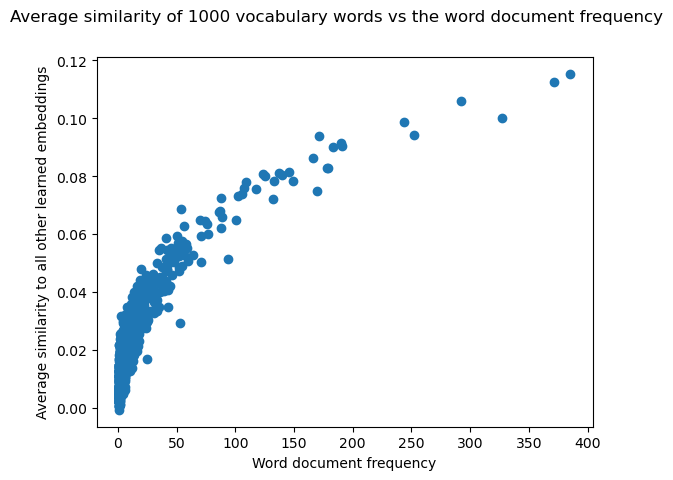

In [29]:
fig, ax = plt.subplots()
fig.suptitle(f"Average similarity of 1000 vocabulary words vs the word document frequency")
ax.scatter(*zip(*avg_similarities))
ax.set_xlabel("Word document frequency")
ax.set_ylabel("Average similarity to all other learned embeddings")